In [1]:
import requests
import nfl_data_py as nfl
import numpy as np
import pandas as pd
import highlight_text as htext
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as path_effects
import matplotlib.font_manager
from PIL import Image
from io import BytesIO

In [2]:
# add font family
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='/home/friend/Downloads/Akzidenz-grotesk-light.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='/home/friend/Downloads/Akzidenz-grotesk-bold.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='/home/friend/Downloads/Akzidenz-grotesk-black.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='/home/friend/Downloads/Akzidenz-grotesk-roman.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='../fonts/Bebas_Neue/BebasNeue-Regular.ttf')

In [3]:
# build team to logo URL dictionary
team_logoURL = {'SF':'https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/San_Francisco_49ers_logo.svg/100px-San_Francisco_49ers_logo.svg.png',
}

In [36]:
team = 'TB'
season = 2022
week = 4
cols = ['game_id','epa','season_type','season','week','drive','series','down','ydstogo','wp','ep','yardline_100','posteam','defteam','game_seconds_remaining','game_half','fixed_drive_result']#'qb_kneel','field_goal_attempt','TD_team','safety','penalty','fumble_lost','interception','fourth_down_failed']
df_pbp = nfl.import_pbp_data(years=[season], columns=cols, downcast=True, cache=False)

2022 done.
Downcasting floats.


In [37]:
conditional_team = (df_pbp['posteam'] == team)
conditional_week = (df_pbp['week'] == week)
is_down = (df_pbp['down'].notnull())
df_team_week_plays = df_pbp[conditional_team & conditional_week & is_down]
df_team_week_plays

,game_id,epa,season_type,week,drive,series,down,ydstogo,wp,ep,yardline_100,posteam,defteam,game_seconds_remaining,game_half,fixed_drive_result,season
9561,2022_04_KC_TB,-0.234484,REG,4,3.0,3.0,1.0,10.0,0.332107,1.635901,72.0,TB,KC,3548.0,Half1,Field goal,2022
9562,2022_04_KC_TB,2.009459,REG,4,3.0,3.0,2.0,7.0,0.319628,1.401417,69.0,TB,KC,3515.0,Half1,Field goal,2022
9563,2022_04_KC_TB,0.552300,REG,4,3.0,4.0,1.0,10.0,0.365555,3.410876,44.0,TB,KC,3470.0,Half1,Field goal,2022
9564,2022_04_KC_TB,-1.220886,REG,4,3.0,5.0,1.0,10.0,0.381803,3.963175,34.0,TB,KC,3434.0,Half1,Field goal,2022
9565,2022_04_KC_TB,0.821761,REG,4,3.0,5.0,2.0,14.0,0.359033,2.742290,38.0,TB,KC,3402.0,Half1,Field goal,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9739,2022_04_KC_TB,0.084583,REG,4,22.0,64.0,1.0,10.0,0.007857,0.238581,79.0,TB,KC,45.0,Half2,End of half,2022
9740,2022_04_KC_TB,-0.133540,REG,4,22.0,65.0,1.0,10.0,0.008996,0.323164,68.0,TB,KC,28.0,Half2,End of half,2022
9741,2022_04_KC_TB,0.684956,REG,4,22.0,65.0,2.0,10.0,0.005830,0.189624,68.0,TB,KC,21.0,Half2,End of half,2022
9742,2022_04_KC_TB,-0.107420,REG,4,22.0,66.0,1.0,10.0,0.012930,0.874581,46.0,TB,KC,12.0,Half2,End of half,2022


In [38]:
df_drives_results_halfs = df_team_week_plays[['drive','fixed_drive_result','game_half']].drop_duplicates(['drive','fixed_drive_result'])
drives = df_drives_results_halfs['drive'].tolist()
results = df_drives_results_halfs['fixed_drive_result'].tolist()
game_halfs = df_drives_results_halfs['game_half'].tolist()
half_idx = game_halfs.index('Half2')
game_halfs.insert(half_idx, 'Halftime')
drives.insert(half_idx, -1)
results.insert(half_idx, '')

height_ratios=[1]*(len(drives)-1)
height_ratios.insert(half_idx,0.1)

league_epa_min =df_pbp.epa.min()
league_epa_max =df_pbp.epa.max()
game_epa_min =df_team_week_plays.epa.min()
game_epa_max =df_team_week_plays.epa.max()

In [39]:
height_ratios

[1, 1, 1, 1, 1, 0.1, 1, 1, 1, 1, 1]

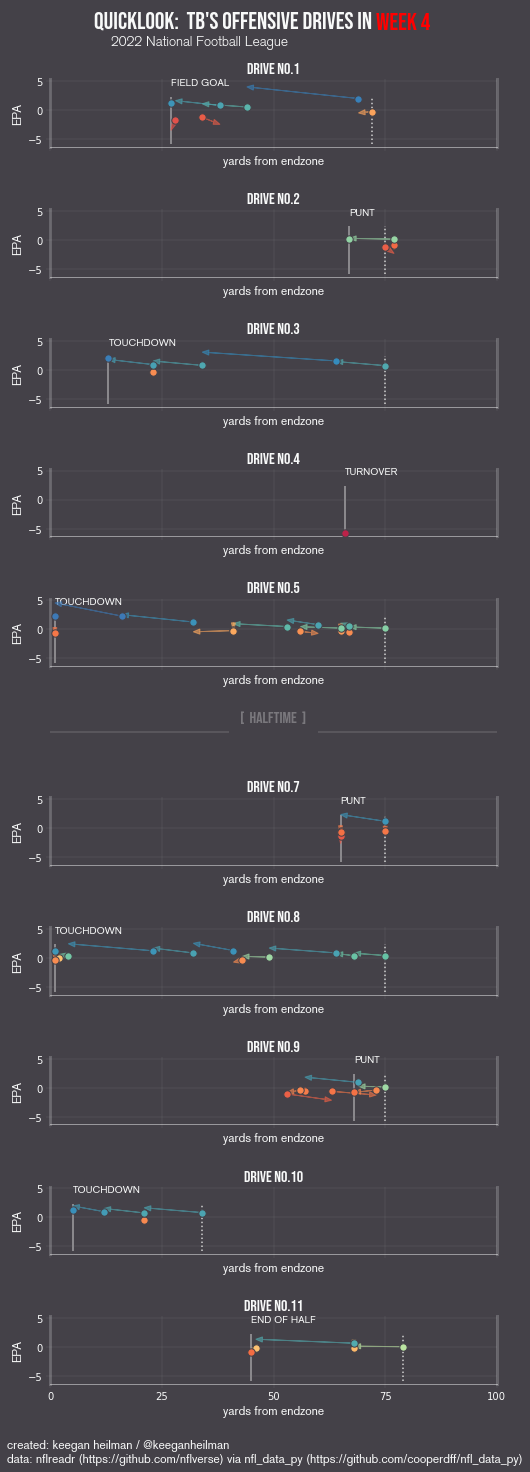

In [40]:
# adjust coloring of downs

font1 = "AkzidenzGrotesk"
font2 =  "Bebas Neue"
font3 = "Loma"
background = "#444148"
text_color = "#F8F9F9"
filler_color = "grey"
primary_color = "red"
drive_start_color = "lightgrey"
# drive_end_color = {"":""}
drive_end_color = "white"
color_map = "Spectral"
first_down = "#CFF3F2"
second_down = "#B2D0CF"
third_down = "#8EA6A5"
fourth_down = "#549694"

title = "Quicklook:  {}'s Offensive Drives in <Week {}>\n"
drive_title = "drive no.{}"
subtitle = "{} National Football League"
credits = "created: keegan heilman / @keeganheilman\ndata: nflreadr (https://github.com/nflverse) via nfl_data_py (https://github.com/cooperdff/nfl_data_py)"

mpl.rcParams['xtick.color'] = text_color
mpl.rcParams['ytick.color'] = text_color

fig = plt.figure(figsize=(8,24))
gs = fig.add_gridspec(len(drives), hspace=1, height_ratios=height_ratios)
axs = gs.subplots(sharex=True, sharey=True)
fig.set_facecolor(background)

cmap = matplotlib.cm.get_cmap(color_map)
norm = mpl.colors.SymLogNorm(linthresh=0.1, vmin=league_epa_min, vmax=league_epa_max)

for drive_idx, (drive, drive_result, game_half) in enumerate(zip(drives, results, game_halfs)):
    if game_half == 'Halftime':
        axs[drive_idx].patch.set_facecolor(background)
        axs[drive_idx].set_title(label='[  halftime  ]', color=text_color, fontweight="light", fontfamily=font2, fontsize=16, alpha=0.3)
        axs[drive_idx].axis("off")
        axs[drive_idx].hlines(y=[-1], xmin=0, xmax=40, colors=[drive_start_color],linestyles="solid", alpha=0.2)
        axs[drive_idx].hlines(y=[-1], xmin=60, xmax=100, colors=[drive_start_color],linestyles="solid", alpha=0.2)
    else:
        x = df_team_week_plays[df_team_week_plays.drive == drive].yardline_100.tolist()
        y = df_team_week_plays[df_team_week_plays.drive == drive].epa.tolist()
        axs[drive_idx].patch.set_facecolor(background)
        axs[drive_idx].grid(ls="-", lw=0.2, color="#838383", zorder=-10)
        axs[drive_idx].set_title(drive_title.format(drive_idx+1), color=text_color, fontweight="light", fontfamily=font2, fontsize=16)
        axs[drive_idx].set_xlim(0,100)
        axs[drive_idx].set_xlabel("yards from endzone",color=text_color,fontfamily=font1, fontsize=12)
        axs[drive_idx].set_ylabel("EPA",color=text_color,fontfamily=font1, fontsize=12)
        axs[drive_idx].tick_params(axis="both",length=4, width=0.2, color="#838383")
        axs[drive_idx].xaxis.set_major_locator(plt.MaxNLocator(4))
      
        spines = ["top", "right", "bottom", "left"]
        for s in spines:
            if s in ["top"]:
                axs[drive_idx].spines[s].set_visible(False)
            elif s in ["left", "right"]:
                axs[drive_idx].spines[s].set_color(text_color)
                axs[drive_idx].spines[s].set_linewidth(3)
                axs[drive_idx].spines[s].set_alpha(.2)
            else:
                axs[drive_idx].spines[s].set_color(text_color)
                axs[drive_idx].spines[s].set_alpha(.6)



        for point_idx, (x_val, y_val) in enumerate(zip(x,y)):
            if point_idx < len(x)-1:
                if point_idx == 0:
                    axs[drive_idx].vlines(x_val, ymin=game_epa_min, ymax=game_epa_max, colors=[drive_start_color],linestyles="dotted")
                axs[drive_idx].arrow(x_val,y_val,
                                     x[point_idx+1]-x_val,y_val,
                                     color=(cmap(norm(y[point_idx]))),
                                     shape="full",
                                     length_includes_head=True,
                                     head_width=0.9,
                                     head_length=1.5,
                                     capstyle="butt",
                                     alpha=0.6,
                                     lw=1,
                                     zorder=5)
            # might assign color to yards to go? or EP?
            if point_idx == len(x)-1:
                axs[drive_idx].vlines(x_val, ymin=game_epa_min, ymax=game_epa_max, colors=[drive_end_color],linestyles="solid", zorder=-5,alpha=0.5)
                axs[drive_idx].text(x=x_val,y=game_epa_max+2, s=drive_result.upper(), color=text_color, fontfamily=font1, fontsize=10)
            axs[drive_idx].scatter(x_val,y_val, color=(cmap(norm(y_val))),edgecolors=background,s=55, alpha=1,lw=1,zorder=10)

        
        
htext.fig_text(s=title.format(team, week),x=0.2, y=0.92, highlight_textprops=[{"color":primary_color,"fontweight":"bold"}], color=text_color, fontsize=24, fontweight="bold", fontfamily=font2)
fig.text(0.23,0.90, subtitle.format(season), fontweight="light", color=text_color,fontfamily=font1, fontsize=14)

# fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs[0], ticks=[10,1,0.1,0,-0.1,-1,-10])

# # add logo
# ax2 = fig.add_axes([0.07,0.87,0.12,0.12])
# ax2.axis("off")
# url ='https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/San_Francisco_49ers_logo.svg/100px-San_Francisco_49ers_logo.svg.png'
# response = requests.get(url)
# img = Image.open(BytesIO(response.content))
# ax2.imshow(img)
             

fig.text(0.05, 0.08,credits, fontstyle="italic", fontweight="roman",fontsize=12, fontfamily=font1, color=text_color)
    
# plt.tight_layout()
plt.show()
plt.close('all')

In [30]:
# How do I want to convey personnel, down and distance, results of drive?


# confirm font family is added
# from IPython.core.display import HTML
# def make_html(fontname):
#     return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)

# code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))])

# HTML("<div style='column-count: 2;'>{}</div>".format(code))